## Scrape NCBI for Vector Genome Stats!!! ##

This is a modification of the EBP tracking script to get just the Vector Genome stats for the R03 to NIAID
The aim is to get the species talked about at Vector base.

The goal of this script is to automagically get a nice table and figure describing the state of the EBP in terms of genomes available at NCBI  
The link is https://www.ncbi.nlm.nih.gov/assembly?term=eucaryotes  
My first alterration from the EBP script is to just look at arthropods:  
https://www.ncbi.nlm.nih.gov/assembly/?term=arthropoda  

The plan is to download the table, parse the data and present it a nice way automatically for easy updates in the future.

### List of graphs and charts I want to make:
1. Assembly quality - x axis contig, y axis scaffold **Done!**
2. EBP quality assemblies by year      **Sorta - go back and Redo!**
3. Draft quality assemblies by year      **Sorta - go abck and Redo!**
4. Families with an EBP quality assembly by year  **Done!**
5. Families with a draft quality assembly by year   **Done!**
6. Total assemblies or any kind by year **Done!**
7. Families with an assembly of any kind by year **Done!**


SO on playing with this a bit more, the easiest thing seems to be to get the XML format file from NCBI.

1. Do this search by clicking this link:
https://www.ncbi.nlm.nih.gov/assembly/?term=arthropoda

2. Click on "send to" - choose destination "file" set the format to "XML" (to get all the data), sort by "Contig N50 down" and finally "Create file"

3. This will download a file called "assembly_result.xml" which is the input to the parsing script.

4. Put this file in the same directory as the images "NCBI_Genome_stats_images" - so the script knows where to look for it.

![Title](NCBI_Genome_stats_images/NCBI_arthropod_assembly_search_sept_2019.png)

### Some code to take the xml and make a tab delimited file to read into pandas ###

In [1]:
# Now import the file, and parse the xml!
# I will do this as it is a straight text file - as I think that is easier than fucking around with xml that gives errors in other peoples parsers
# for now just make a tab delimited file and open it in pandas

import re

xml_file = "NCBI_Genome_stats_images/assembly_result.xml"
out_file = xml_file + "_tab_delimited_file.txt"
fhout = open(out_file, mode='w')
fhout.write("species\tcontig_n50\tscaffold_n50\ttotal_length\tstatus\tass_accession\tass_release_date\n")
species_count = 0
with open(xml_file) as xml_fh:
    for line in xml_fh:
        
        search_obj_acc = re.search('<AssemblyAccession>(.+)<', line)
        search_obj_species = re.search('<SpeciesName>(.+)</SpeciesName>', line)
        search_obj_ass_status = re.search('<AssemblyStatus>(.+)</AssemblyStatus>', line)
        search_obj_ass_release_date = re.search('<AsmReleaseDate_GenBank>(\d+/\d+/\d+).+</AsmReleaseDate_GenBank>', line)
        search_obj_contig_n50 = re.search('<ContigN50>(\d+)</ContigN50>', line)
        search_obj_scaf_n50 = re.search('<ScaffoldN50>(\d+)</ScaffoldN50>', line)
        search_obj_end_record = re.search('</DocumentSummary>', line)
        search_obj_total_length = re.search('total_length&quot; sequence_tag=&quot;all&quot;&gt;(\d+)&lt', line)

        
        if search_obj_acc:
            ass_accession = search_obj_acc.group(1)
            #print(search_obj_acc.group(1))
        if search_obj_species:
            species = search_obj_species.group(1)
            #print(search_obj_species.group(1))
        if search_obj_ass_status:
            status = search_obj_ass_status.group(1)
            #print(search_obj_ass_status.group(1))
        if search_obj_ass_release_date:
            ass_release_date = search_obj_ass_release_date.group(1)
            #print(search_obj_ass_release_date.group(1))
        if search_obj_contig_n50:
            contig_n50 = search_obj_contig_n50.group(1)
            #print(search_obj_contig_n50.group(1), "bp")
        if search_obj_scaf_n50:
            scaffold_n50 = search_obj_scaf_n50.group(1)
            #print("scaffold_n50 =", scaffold_n50)
            #print(search_obj_scaf_n50.group(1), "bp")
        if search_obj_total_length:
            total_length = search_obj_total_length.group(1)
        
        if search_obj_end_record:
            print_line = species + "\t" + contig_n50 + "\t" + scaffold_n50 + "\t" + total_length + "\t" +  status + "\t" + ass_accession + "\t" + ass_release_date + "\n"
            #print(print_line)
            fhout.write(print_line)
            species_count = species_count + 1
print("species_count = ", species_count)
fhout.close()

('species_count = ', 766)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [3]:
#df = pd.read_csv("NCBI_Genome_stats_images/assembly_result.xml_tab_delimited_file.txt", delimiter="\t")
df = pd.read_csv(out_file, delimiter="\t")

In [4]:
df.head(3)

,species,contig_n50,scaffold_n50,total_length,status,ass_accession,ass_release_date
0,Drosophila pseudoobscura,26005469,30730540,164662283,Chromosome,GCA_000001765.3,2018/06/28
1,Drosophila simulans,22909593,24213528,146773509,Chromosome,GCA_004382185.1,2019/04/16
2,Drosophila melanogaster,22407379,25025258,140687039,Chromosome,GCA_003401745.1,2018/08/17


In [5]:
df['species'].count()

766

In [6]:
# try to remove duplicate species, but keep the longest contig N50
df_sorted_no_dups = df.sort_values('contig_n50', ascending=False).drop_duplicates(subset=['species'])
df_sorted_no_dups = df_sorted_no_dups.reset_index(drop=True)
df_sorted_no_dups.head(3)

,species,contig_n50,scaffold_n50,total_length,status,ass_accession,ass_release_date
0,Drosophila pseudoobscura,26005469,30730540,164662283,Chromosome,GCA_000001765.3,2018/06/28
1,Drosophila simulans,22909593,24213528,146773509,Chromosome,GCA_004382185.1,2019/04/16
2,Drosophila melanogaster,22407379,25025258,140687039,Chromosome,GCA_003401745.1,2018/08/17


In [7]:
df_sorted_no_dups['species'].count()

490

In [8]:
df_sorted_no_dups['status'].describe()

count          490
unique           3
top       Scaffold
freq           404
Name: status, dtype: object

### Grab genera from species name 

In [9]:
new_df = df_sorted_no_dups['species'].str.split(" ", n=1, expand=True)
print(new_df.head(2))
df_sorted_no_dups['genera'] = new_df[0]
df_sorted_no_dups['species_only'] = new_df[1]
df_sorted_no_dups.head()

            0              1
0  Drosophila  pseudoobscura
1  Drosophila       simulans


,species,contig_n50,scaffold_n50,total_length,status,ass_accession,ass_release_date,genera,species_only
0,Drosophila pseudoobscura,26005469,30730540,164662283,Chromosome,GCA_000001765.3,2018/06/28,Drosophila,pseudoobscura
1,Drosophila simulans,22909593,24213528,146773509,Chromosome,GCA_004382185.1,2019/04/16,Drosophila,simulans
2,Drosophila melanogaster,22407379,25025258,140687039,Chromosome,GCA_003401745.1,2018/08/17,Drosophila,melanogaster
3,Drosophila erecta,22146549,22146549,146538397,Contig,GCF_003286155.1,2018/10/23,Drosophila,erecta
4,Drosophila mauritiana,22120385,24228064,152317181,Chromosome,GCA_004382145.1,2019/04/16,Drosophila,mauritiana


## Function to add higher taxonomic info to dataframe to allow by family or kingdom ect ##

In [13]:
# function to take a pandas lambda df thing species name and return a family name using the above ideas
### WHAT A COMPLETE PAIN IN THE ASS TO FIND OUT THIS IS WHAT WAS NEEDED
import requests
import re

def DF_get_family_name_given_species_name(df):
    """
    This is a short function to get a family name from the GBIF rest api given a genus_species name
    example input: Homo sapiens
    example return: Hominidae
    It requires re, requests functions
    NOTE!!! - Homo Sapiens doesn't work, Homo sapiens does - CHECK SPELLING
    """
    family = ''
    order = ''
    taxon_class = ''
    phylum = ''
    
    search_url_string = "http://api.gbif.org/v1/species/match?&name=" + df['species']
    res = requests.get(search_url_string)
    if res.status_code == 200:
        #print(res.text)
        #print("search string = ", search_url_string)
        search_obj_family = re.search(',"family":"(.+?)",', res.text)
        if search_obj_family:
            family = search_obj_family.group(1)
        else:
            #print("no family name returned for species name:", species)
            #print(".", end="")
            family = None
        
        search_obj_order = re.search(',"order":"(.+?)",', res.text)
        if search_obj_order:
            order = search_obj_order.group(1)
        else:
            #print("no order name returned for species name:", species)
            #print(".", end="")
            order = None
        
        search_obj_class = re.search(',"class":"(.+?)"', res.text)
        if search_obj_class:
            taxon_class = search_obj_class.group(1)
        else:
            #print("no class name returned for species name:", species)
            #print(".", end="")
            taxon_class = None
        
        search_obj_phylum = re.search(',"phylum":"(.+?)"', res.text)
        if search_obj_phylum:
            phylum = search_obj_phylum.group(1)
        else:
            #print("no phylum name returned for species name:", species)
            #print(".", end="")
            phylum = None
            
        search_obj_kingdom = re.search(',"kingdom":"(.+?)"', res.text)
        if search_obj_kingdom:
            kingdom = search_obj_kingdom.group(1)
        else:
            #print("no kingdom name returned for species name:", species)
            #print(".", end="")
            kingdom = None
            
        #print("got:", family, order, taxon_class, phylum, kingdom)
        df['family'] = family
        df['order'] = order
        df['class'] = taxon_class
        df['phylum'] = phylum
        df['kingdom'] = kingdom
    
    return(df)

# test this out - # Create the pandas DataFrame 
data = [['Homo sapiens', "test"], ['Drosophila melanogaster', "test 2"]] 
df_test_taxon = pd.DataFrame(data, columns = ['species', 'something']) 
print(df_test_taxon)  

# test the above function
df_test_taxon = df_test_taxon.apply(DF_get_family_name_given_species_name, axis=1)
df_test_taxon

                   species something
0             Homo sapiens      test
1  Drosophila melanogaster    test 2


,species,something,family,order,class,phylum,kingdom
0,Homo sapiens,test,Hominidae,Primates,Mammalia,Chordata,Animalia
1,Drosophila melanogaster,test 2,Drosophilidae,Diptera,Insecta,Arthropoda,Animalia


## Don't re-run this next cell unless redoing everything - it goes to GBIF for every species name  
## need to work on a full download to local storage. ##

In [ ]:
# this takes time and goes to the Web for every species - uncomment line to redo as needed.
## uncomment the next line to run - takes 50 mins???
df_sorted_no_dups = df_sorted_no_dups.apply(DF_get_family_name_given_species_name, axis=1)
df_sorted_no_dups.head(3)

In [ ]:
df_sorted_no_dups.head(3)

### Plot of Contig N50 vs Scaffold N50

In [ ]:
def plot_contig_N50_vs_scaffold_N50(df, title, point_size=400):
    '''A function to take in a dataframe with the same columns as everrytthing else on this jupyter workbook, and output a plot
    of contig N50 vs Scaffold N50
    Inputs 1. the df, 2 a title for the plot
    Optional input point_size=300, labels=True
    '''
    
    date = datetime.date.today()
    sns.set_style("whitegrid")

    g = sns.lmplot(x='contig_n50', y='scaffold_n50', data=df, hue='status', fit_reg=False, height=18, aspect=1.4, legend_out=False, scatter_kws={"s":point_size} )

    # Set the `yscale` and other things
    g.set(yscale="log")
    g.set(xscale="log")
    g.set(ylim=[100, 10000000000])
    g.set(xlim=[100, 100000000])
    
    plt.axvspan(1000000, 10000000000, ymin=0.625, ymax=1, alpha=0.1, color='red')
    plt.axvspan(100000, 1000000000, ymin=0.5, ymax=1, alpha=0.1, color='yellow')

    plt.xlabel('Contig N50 (bp)', fontweight='normal', color = 'black', fontsize=32, horizontalalignment='center')
    plt.ylabel('Scaffold N50 (bp)', fontweight='normal', color = 'black', fontsize=32, horizontalalignment='center')
    title_string = title + " (As of " + str(date.today()) + ")" 
    plt.title(title_string, fontweight='bold', color = 'black', fontsize='36', loc='center')
    plt.legend(loc = 'lower right', title = "NCBI status", fontsize = 16)
        
    # for line in range(0,df.shape[0]):  # gave up on adding the names to the dots.
    #    g.text(df.contig_n50[line]+0.2, df.scaffold_n50[line], df.species[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

    # Show plot
    #plt.show()
    file_name = "NCBI_Genome_stats_images/Arthropod_Contig_and_scaffold_N50_plot_" + str(date.today()) + ".png"
    plt.savefig(file_name)

# test function
plot_contig_N50_vs_scaffold_N50(df_sorted_no_dups, 'NCBI Arthropod assembly contiguity stats', point_size=400)

## Or plot with plotly???

In [ ]:
import plotly.express as px
import plotly
def plot_with_plotly(df, title = 'arthropod genome assembly stats'):
    ''' input a dataframe from this worksheet, second input is a title'''
    fig = px.scatter(df, x='contig_n50', y='scaffold_n50', color='status', hover_data=['species'], log_x=True, log_y=True, template='plotly_white', title=title)
    fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.update_traces(textposition='top center')
    plotly.offline.plot(fig, filename='NCBI_Genome_stats_images/arthropod_genome_assembly_stats.html') # saves the html file
    fig.show()

plot_with_plotly(df_sorted_no_dups, 'athropod genome assembly stats')

In [ ]:
# try and plot assemblies by year - first add year column to dataframe
df_sorted_no_dups['date_time_test'] = pd.to_datetime(df_sorted_no_dups['ass_release_date'])
df_sorted_no_dups['year'] = df_sorted_no_dups['date_time_test'].apply(lambda x: x.year)
print(type(df_sorted_no_dups['year'][0]))
df_sorted_no_dups.head(3)

In [ ]:
# MAKE A DATA FRAME WITH HIGH QUALITY ASSEMBLIES
df_contig_N50_OK = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>1000000]
#df_contig_N50_OK.tail()
df_scaf_and_contig_OK = df_contig_N50_OK[df_contig_N50_OK['scaffold_n50']>10000000]
df_complete_genome = df_sorted_no_dups[df_sorted_no_dups['status'] == 'Complete Genome']
df_all_passing = pd.concat([df_scaf_and_contig_OK, df_complete_genome])
df_all_passing = df_all_passing.drop_duplicates()
print("number of species passing VGP qual (no dups):", df_all_passing['species'].count())


In [ ]:
df_draft_contig_N50_OK = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>100000]
#df_contig_N50_OK.tail()
df_draft_scaf_and_contig_OK = df_draft_contig_N50_OK[df_draft_contig_N50_OK['scaffold_n50']>1000000]
df_complete_genome = df_sorted_no_dups[df_sorted_no_dups['status'] == 'Complete Genome']
df_draft_all_passing = pd.concat([df_draft_scaf_and_contig_OK, df_complete_genome])
print("number of draft all passing = ", df_draft_all_passing['species'].count())
df_draft_all_passing = df_draft_all_passing.drop_duplicates()
print("number of draft all passing after dup removal = ", df_draft_all_passing['species'].count())  # seems to have worked


In [ ]:
# just for me
print("total number of Arthropod assemblies = ", df_sorted_no_dups['species'].count())
df_sorted_no_dups.to_excel('NCBI_Genome_stats_images/arthropod_assembly_stats_oct1st_2019.xlsx')

## Write a nice report - this needs to be put into Markdown for an easy nice output

In [ ]:
# make a summary stats file
import datetime
date = datetime.date.today()
print("date of NCBI stats download = ", date)

total_non_redundant_assemblies = df_sorted_no_dups['species'].count()
print("total_non_redundant_assemblies of Arthropods = ", total_non_redundant_assemblies)
NCBI_complete_genome_assemblies = df_sorted_no_dups[df_sorted_no_dups['status'] == "Complete Genome"]['species'].count()
print("NCBI complete genome status of Arthropods = ", NCBI_complete_genome_assemblies)
NCBI_chromosome_assemblies = df_sorted_no_dups[df_sorted_no_dups['status'] == "Chromosome"]['species'].count()
print("NCBI chromosome status of Arthropods = ", NCBI_chromosome_assemblies)
print("Question: What is the definition of complete genome and or chromosome status at NCBI???")

print("\n")

contig_N50_greater_than_1Mb = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>1000000]['species'].count()
print("Arthropods: contig_N50_greater_than_1Mb =", contig_N50_greater_than_1Mb)

scaffold_n50_greater_than_10Mb = df_sorted_no_dups[df_sorted_no_dups['scaffold_n50']>10000000]['species'].count()
print("Arthropods: scaffold_n50_greater_than_10Mb =", scaffold_n50_greater_than_10Mb)

VGP_standard = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>=1000000][df_sorted_no_dups['scaffold_n50']>=10000000]['species'].count()
percent_VGP_standard = VGP_standard / 1500000 * 100
print("Arthropods: meets VGP standard (1Mb contig N50, 10Mb Scaffold N50) =", VGP_standard, "or", percent_VGP_standard, "%")


print("\n")
contig_N50_greater_than_100Kb = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>100000]['species'].count()
print("Arthropods: contig_N50_greater_than_100Kb =", contig_N50_greater_than_100Kb)

scaffold_n50_greater_than_1Mb = df_sorted_no_dups[df_sorted_no_dups['scaffold_n50']>1000000]['species'].count()
print("Arthropods: scaffold_n50_greater_than_1Mb =", scaffold_n50_greater_than_1Mb)

Lower_standard = df_sorted_no_dups[df_sorted_no_dups['contig_n50']>=100000][df_sorted_no_dups['scaffold_n50']>=1000000]['species'].count()
percent_lower_standard = Lower_standard / 1500000 * 100
print("Arthropods: meets draft standard (100kb contig N50, 1Mb scaffold N50) =", Lower_standard, "or", percent_lower_standard, "%")

### THE BELOW IS IN PROGRESS TO MAKE THE REPORT LOOK NICE ###

In [ ]:
# print to markdown file for the poster:
FHOUT = open('NCBI_Genome_stats_images/stats_table.md', 'w')
FHOUT.write("""

date of NCBI stats download = %d



""")
print(""" 
Colons can be used to align columns.

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned | $1600 |
| col 2 is      | centered      |   $12 |
| zebra stripes | are neat      |    $1 |
      
""")

# 2. make the main markdown file
report = '''
### Analysis of {}  
Reference = {}

**Total sequence = _{} bp_**  
**Good sequence = _{} bp ({}%)_**  
  
![alt text]({} "{}")

|                          |  All reads     | Alignable reads | Reads > 2kb and 80% ident |  >20kb, >80% ident |
|--------------------------|:--------------:|:---------------:|:-------------------------:|:------------------:|
| Number of reads          |   {}           |      {}         |        {} ({}%)           |     {} ({}%)       | 
| Total sequence (bp)      |   {}           |      {}         |        {} ({}%)           |     {} ({}%)       |
| Longest read (bp)        |   {}           |      {}         |        {}                 |           -        |       
| longest read accuracy (%)|   {}           |      {}         |        {}                 |           -        |
| Mean read length (bp)    |   {}           |      {}         |        {}                 |           -        |
| Median read length (bp)  |   {}           |      {}         |        {}                 |           -        |
| Max read length bin (bp) |   {}           |      {}         |        {}                 |           -        |
| Mean read accuracy (%)   |   {}           |      {}         |        {}                 |           -        |
| Median read accuracy (%) |   {}           |      {}         |        {}                 |           -        |
| Max read identity bin (%)|   {}           |       -         |         -                 |           -        |

Report generated using the script run_nanopore_alignment_and_stats_pipeline.py by Stephen Richards stephenr@bcm.edu  
Start time: {}, End time: {}, Run time: {}, Run time per Gb: {}  
Methods: ONT reads aligned with {}, identities identified with samtools calmd, stats generated using pandas.  
Cost per 100Gb 30X human genome with {}bp sequence yield runs = ${} on MinION assuming $1,000/run PromethION is ~half that cost at low volume and ~1/5th cost at high volume (${})
'''.format(output_name,
           ref,
           all_reads_seq,
           good_reads_seq,
           good_reads_seq_percent,
           histogram,
           histogram_text,
           num_reads,
           num_aligned_reads,
           num_good_reads,
           num_good_reads_percent,
           num_good_long_reads,
           num_good_long_reads_percent,
           all_reads_seq,
           aligned_reads_seq,
           good_reads_seq,
           good_reads_seq_percent,
           good_long_reads_seq,
           good_long_reads_seq_percent,
           longest_read,
           longest_aligned_read,
           longest_good_read,
           longest_read_ident,
           longest_aligned_read_ident,
           longest_good_read_ident,
           mean_read_length,
           mean_aligned_read_length,
           mean_good_read_length,
           peak_read_length,
           peak_aligned_read_length,
           peak_good_read_length,
           max_read_length_bin_all_reads,
           max_read_length_bin_aligned_reads,
           max_read_length_bin_good_reads,
           mean_read_accuracy,
           mean_aligned_read_accuracy,
           mean_good_read_accuracy,
           peak_read_accuracy,
           peak_aligned_read_accuracy,
           peak_good_read_accuracy,
           max_read_identity_bin,
           start_time,
           end_time,
           run_time,
           run_time_per_gb,
           aligner,
           good_reads_seq,
           cost_per_100gb, 
           promethION_cost_per_100gb)



## Question ##
### What is the definition of complete genome and chromosome status at NCBI??? ###

In [ ]:
# use a pivot table to get number of families in df_all_passing
#df_all_passing_by_family = df_all_passing.pivot_table(columns="species" , values='family')
#df_all_passing_by_family
print("total number of passing species = ", df_all_passing['species'].count())

df_all_passing_by_family = pd.pivot_table(df_all_passing, index=['family'])
#df_all_passing_by_family = df_all_passing.groupby(by='family')
print(df_all_passing_by_family.count())
print("total number of passing families = ", df_all_passing_by_family['contig_n50'].count())

In [ ]:
# and again for draft quality
print("total number of passing species = ", df_draft_all_passing['species'].count())
df_draft_all_passing_by_family = pd.pivot_table(df_draft_all_passing, index=['family'])
df_draft_all_passing_by_family.count()

In [ ]:
print("total species = ", df_all_passing['species'].count())
min_year = df_all_passing['year'].min()
max_year = df_all_passing['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Cumulative VGP quality species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_assembly = df_all_passing[df_all_passing['year'] <= year_count]['species'].count()
    #print("number of cumulative species passing = ",  cum_species_with_assembly)
    lst.append([int(year_count), int(cum_species_with_assembly)])

df_cumulative_species = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_species

In [ ]:
print("total species = ", df_draft_all_passing['species'].count())
#min_year = df_draft_all_passing['year'].min()
min_year = 2010
max_year = df_draft_all_passing['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Cumulative 100kb contig N50 species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_draft_assembly = df_draft_all_passing[df_draft_all_passing['year'] <= year_count]['species'].count()
    #print("number of cumulative species passing draft qual = ",  cum_species_with_draft_assembly)
    lst.append([int(year_count), int(cum_species_with_draft_assembly)])

df_cumulative_draft_species = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_draft_species

In [ ]:
print("total species = ", df_sorted_no_dups['species'].count())
#min_year = df_sorted_no_dups['year'].min()
min_year = 2010  # because a lot of older assemblies had updates - so not much before 2010 unless you look at the originals
max_year = df_sorted_no_dups['year'].max()
print("min_year = ", min_year, "max_year = ", max_year)

cols = ['Year', 'Any assembly: Cumulative species represented']
lst = []

for year_count in range(min_year, max_year+1):
    #print("year = ", year_count)
    cum_species_with_any_assembly = df_sorted_no_dups[df_sorted_no_dups['year'] <= year_count]['species'].count()
    #print("number of cumulative species any assembly quality = ",  cum_species_with_any_assembly)
    lst.append([int(year_count), int(cum_species_with_any_assembly)])

df_cumulative_species_any_assembly = pd.DataFrame(lst, columns=cols)
#df_cumulative_families_represented.set_index('Year', inplace=True)
df_cumulative_species_any_assembly

### Note there are a lot of updated and not original genomes in here,  
- lots of old genome assemblies replaced by an updated version - seemed to happen a lot in 2010  
- So I made 2010 the first year of the plot for now  
- Will think about a more accurate historical view later

In [ ]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(24,6))

df_cumulative_species_any_assembly.plot(ax=axes[0,0], x='Year', y='Any assembly: Cumulative species represented', kind='bar', width=1, color='red', title="Cumulative number of species with any assembly")
df_cumulative_draft_species.plot(ax=axes[0,1],  x='Year', y='Cumulative 100kb contig N50 species represented', kind='bar', width=1, color='orange', title='Cumulative number of species with Draft quality assembly')
df_cumulative_species.plot(ax=axes[0,2], x='Year', y='Cumulative VGP quality species represented', kind='bar', width=1, color='green', title="Cumulative number of species with VGP quality assembly")

plt.savefig('NCBI_Genome_stats_images/Cumulative_species_by_year.png')

In [ ]:
# keep cell in case I need a single plot
#sns.set_style('darkgrid')
#df_cumulative_species_any_assembly.plot(x='Year', y='Any assembly: Cumulative species represented', kind='bar', width=1, color='red', title="Cumulative number of species with any assembly", figsize=(8,6) )
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_any_assembly.png')

In [54]:
# Keep cell incase I need a single plot
#df_cumulative_draft_species.plot(x='Year', y='Cumulative 100kb contig N50 species represented', kind='bar', width=1, color='orange', title='Cumulative number of species with Draft quality assembly', figsize=(8,6))
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_Draft_quality_assembly.png')

In [55]:
# Keep cell in case I need a single plot
#df_cumulative_species.plot(x='Year', y='Cumulative VGP quality species represented', kind='bar', width=1, color='green', title="Cumulative number of species with VGP quality assembly", figsize=(8,6) )
#plt.savefig('NCBI_Genome_stats_images/Cumulative_num_species_with_EBP_quality_assembly.png')

## Now I need to plot the same progress by different taxonomic rank  
- If I were smart this would be a cool loop with three charts for each rank in a cool grid pattern

In [56]:
df_all_passing.head(1)

,species,contig_n50,scaffold_n50,total_length,status,ass_accession,ass_release_date,genera,species_only,date_time_test,year
0,Drosophila pseudoobscura,26005469,30730540,164662283,Chromosome,GCA_000001765.3,2018/06/28,Drosophila,pseudoobscura,2018-06-28,2018


('\ntotal species at this quality = ', 490)
('\ntotal species at this quality = ', 74)
('\ntotal species at this quality = ', 19)


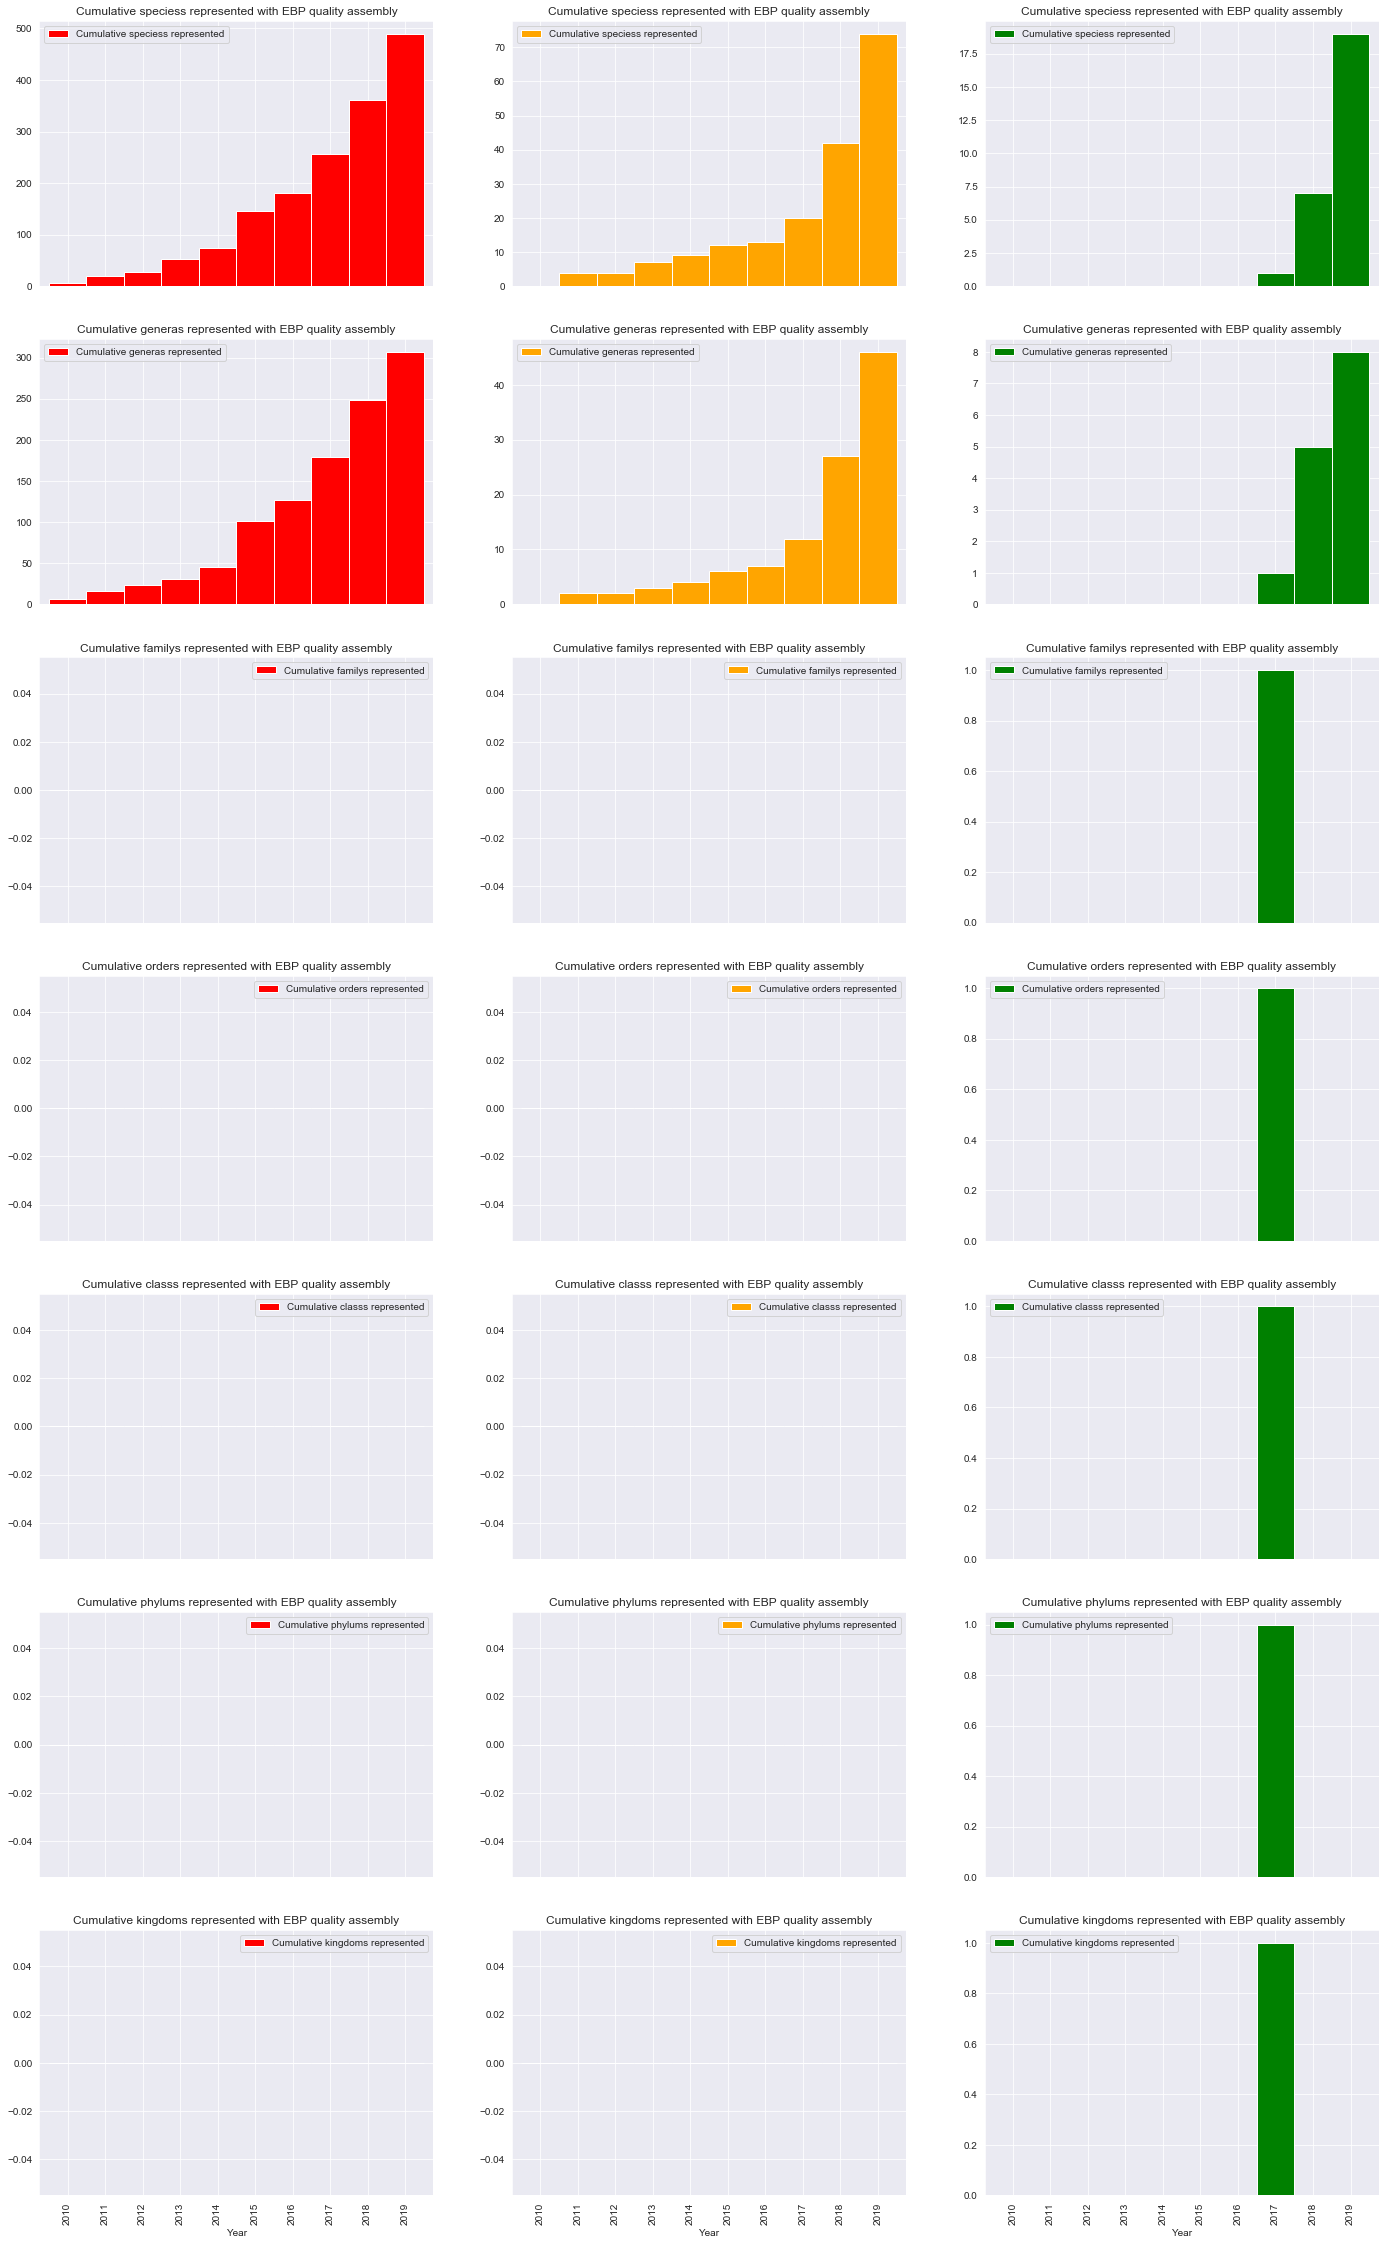

In [57]:
# trying to get all the charts in a single loop
df_sorted_no_dups.name = 'all'  # I named them for the coloring below
df_draft_all_passing.name = 'draft'
df_all_passing.name = 'VGP'

sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=7, ncols=3, squeeze=False, figsize=(24,40), sharex=True)

for loop_dfs in (df_sorted_no_dups, df_draft_all_passing, df_all_passing):
    print("\ntotal species at this quality = ", loop_dfs['species'].count())
    for rank in ('species', 'genera', 'family', 'order', 'class', 'phylum', 'kingdom'):
        taxon_column = "Cumulative " + rank + "s represented"
        cols = ['Year', taxon_column]
        lst = []

        for year_count in range(min_year, max_year+1):
            #print("year = ", year_count)
            #print(df_all_passing[df_all_passing['year'] <= year_count]['species'].count())
            #print(loop_dfs[loop_dfs['year'] <= year_count]['species'].count())
            
            #familes_with_assembly = pd.pivot_table(df_all_passing[df_all_passing['year'] <= year_count], index=[rank])['contig_n50'].count()
            familes_with_assembly = 0
            try:
                familes_with_assembly = pd.pivot_table(loop_dfs[loop_dfs['year'] <= year_count], index=[rank])['contig_n50'].count()
            except:
                families_with_assembly = 0
            #print("number of cumulative ", rank, " passing = ",  familes_with_assembly)
            lst.append([int(year_count), int(familes_with_assembly)])

        df_cumulative_families_represented = pd.DataFrame(lst, columns=cols)
        #df_cumulative_families_represented.set_index('Year', inplace=True)
        #print(df_cumulative_families_represented)

        title_label = taxon_column + " with EBP quality assembly"
        bar_color = 'orange'
        plot_col = 0
        plot_row = 0
        
        if loop_dfs.name == "all":
            bar_color = 'red'
            plot_col = 0
        elif loop_dfs.name == 'draft':
            bar_color = 'orange'
            plot_col = 1
        elif loop_dfs.name == 'VGP':
            bar_color = 'green'
            plot_col = 2
        
        if rank == 'species':
            plot_row = 0
        elif rank == 'genera':
            plot_row = 1
        elif rank == 'family':
            plot_row = 2      
        elif rank == 'order':
            plot_row = 3
        elif rank == 'class':
            plot_row = 4
        elif rank == 'phylum':
            plot_row = 5
        elif rank == 'kingdom':
            plot_row = 6

        df_cumulative_families_represented.plot(ax=axes[plot_row, plot_col], x='Year', y=taxon_column, kind='bar', width=1, color=bar_color, title=title_label )

plt.savefig('NCBI_Genome_stats_images/taxonomic_rank_progress_by_year.png')

In [58]:
df_species_draft_seq_in_each_class = pd.pivot_table(data=df_draft_all_passing, index='class', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_draft_seq_in_each_class

KeyError: 'class'

In [ ]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups[df_sorted_no_dups['phylum']=='Arthropoda'], index='order', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='orange', title='Number of Arthropod species with any assembly by Order', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_arthropod_assembly_by_order.png')

In [ ]:
df_species_any_seq_in_each_class = pd.pivot_table(data=df_sorted_no_dups[df_sorted_no_dups['order']=='Diptera'], index='family', values='species', aggfunc=lambda x: len(x.unique()), fill_value=0)
df_species_any_seq_in_each_class.plot(y='species', kind='bar', width=0.9, color='orange', title='Number of Arthropod species with any assembly', figsize=(30,8))
plt.savefig('NCBI_Genome_stats_images/Any_diptera_assembly_by_family.png')

# How many are _Drosophila_??? 69!

In [59]:
df_sorted_no_dups[df_sorted_no_dups['genera'] == 'Drosophila']['species']

0      Drosophila pseudoobscura
1           Drosophila simulans
2       Drosophila melanogaster
3             Drosophila erecta
4         Drosophila mauritiana
5          Drosophila sechellia
6             Drosophila azteca
7          Drosophila athabasca
8            Drosophila miranda
10        Drosophila subobscura
13           Drosophila virilis
16         Drosophila ananassae
18             Drosophila orena
19        Drosophila persimilis
20             Drosophila lowei
23             Drosophila hydei
26      Drosophila novamexicana
27          Drosophila innubila
37           Drosophila serrata
44         Drosophila biarmipes
59          Drosophila kanapiae
66           Drosophila guanche
69        Drosophila ficusphila
74        Drosophila eugracilis
76           Drosophila elegans
78           Drosophila birchii
79          Drosophila kikkawai
86        Drosophila willistoni
93           Drosophila busckii
96       Drosophila bipectinata
                 ...           
121     

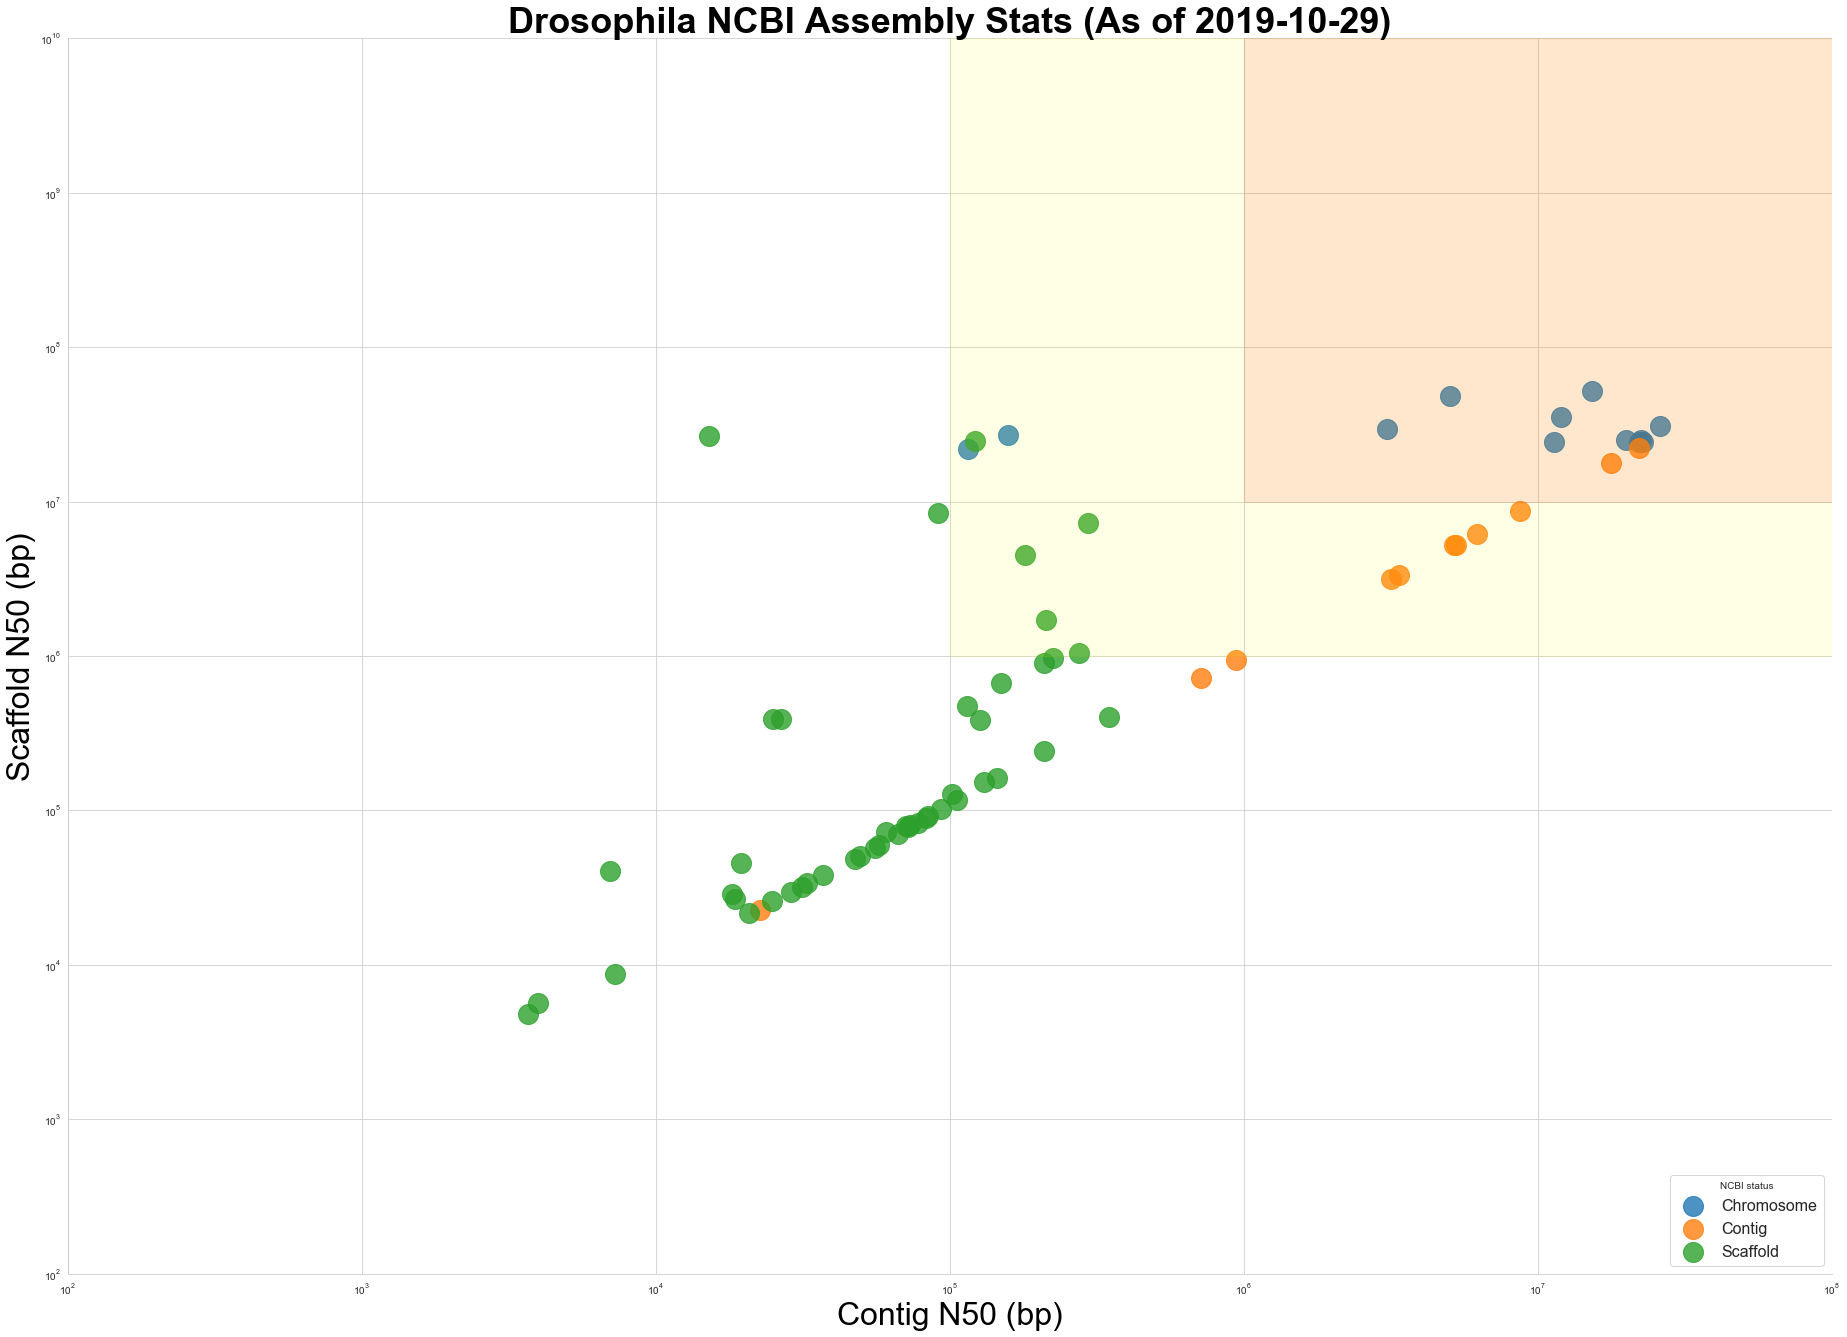

In [60]:
# plot out the assembly qualities
df_Drosophila = df_sorted_no_dups[df_sorted_no_dups['genera'] == 'Drosophila']
plot_contig_N50_vs_scaffold_N50(df_Drosophila, 'Drosophila NCBI Assembly Stats')
plot_with_plotly(df_Drosophila, 'Drosophila Genome Assembly Statistics')

# But I just want the vector base species

In [61]:
# The vector base species are (Non redundant as there are some important sub species):
species = ['Aedes aegypti', 'Aedes albopictus', 'Anopheles albimanus', 'Anopheles arabiensis', 'Anopheles atroparvus', 'Anopheles christyi', \
           'Anopheles coluzzii',\
           'Anopheles culicifacies','Anopheles darlingi','Anopheles dirus','Anopheles epiroticus','Anopheles farauti','Anopheles funestus',\
           'Anopheles gambiae', 'Anopheles maculatus', 'Anopheles melas', 'Anopheles merus', 'Anopheles minimus', 'Anopheles quadriannulatus',\
           'Anopheles sinensis', 'Anopheles stephensi', 'Biomphalaria glabrata', 'Cimex lectularius', 'Culex quinquefasciatus', 'Glossina austeni',\
           'Glossina brevipalpis', 'Glossina fuscipes', 'Glossina morsitans', 'Glossina pallidipes', 'Glossina palpalis', 'Ixodes scapularis', \
           'Leptotrombidium deliense', 'Lutzomyia longipalpis', 'Musca domestica', 'Pediculus humanus', 'Phlebotomus papatasi', 'Rhodnius prolixus',\
           'Sarcoptes scabiei', 'Stomoxys calcitrans']
df_vectorbase = pd.DataFrame(species, columns=['species'])
df_vectorbase = df_vectorbase.merge(df_sorted_no_dups, on='species')
df_vectorbase

,species,contig_n50,scaffold_n50,total_length,status,ass_accession,ass_release_date,genera,species_only,date_time_test,year
0,Aedes aegypti,11758062,409777670,1278732104,Chromosome,GCF_002204515.2,2017/06/27,Aedes,aegypti,2017-06-27,2017
1,Aedes albopictus,3303944,3303944,2247306217,Contig,GCF_001876365.2,2017/01/09,Aedes,albopictus,2017-01-09,2017
2,Anopheles albimanus,200121,9735467,173339239,Chromosome,GCA_000349125.2,2017/08/01,Anopheles,albimanus,2017-08-01,2017
3,Anopheles arabiensis,74117,5604218,246567867,Scaffold,GCA_000349185.1,2013/04/08,Anopheles,arabiensis,2013-04-08,2013
4,Anopheles atroparvus,53613,9206694,224290125,Scaffold,GCA_000473505.1,2013/10/21,Anopheles,atroparvus,2013-10-21,2013
5,Anopheles christyi,8461,9057,172658580,Scaffold,GCA_000349165.1,2013/04/08,Anopheles,christyi,2013-04-08,2013
6,Anopheles coluzzii,2625112,2625112,340556243,Contig,GCA_004136515.2,2019/02/06,Anopheles,coluzzii,2019-02-06,2019
7,Anopheles culicifacies,13414,22320,202998806,Scaffold,GCA_000473375.1,2013/10/21,Anopheles,culicifacies,2013-10-21,2013
8,Anopheles darlingi,115072,115072,136935538,Contig,GCA_000211455.3,2013/12/20,Anopheles,darlingi,2013-12-20,2013
9,Anopheles dirus,76300,6906475,216307690,Scaffold,GCA_000349145.1,2013/04/08,Anopheles,dirus,2013-04-08,2013


In [62]:
# make the names shorter for better presentation
df_vectorbase['name_abreviation'] = df_vectorbase['genera'].astype(str).str[0] + " " + df_vectorbase.species_only
df_vectorbase.head(1)


,species,contig_n50,scaffold_n50,total_length,status,ass_accession,ass_release_date,genera,species_only,date_time_test,year,name_abreviation
0,Aedes aegypti,11758062,409777670,1278732104,Chromosome,GCF_002204515.2,2017/06/27,Aedes,aegypti,2017-06-27,2017,A aegypti


In [63]:
plot_with_plotly(df_vectorbase, 'NCBI Assembly Statistics of Vector Genomes')

In [64]:
# Average contig N50 size
print("mean vector genome contig N50:",df_vectorbase['contig_n50'].mean())
print("median vector genome contig N50:",df_vectorbase['contig_n50'].median())
print("longest vector genome contig N50:",df_vectorbase['contig_n50'].max())
print("shortest vector genome contig N50:",df_vectorbase['contig_n50'].min())
print("\n")
print("mean vector genome scaffold N50:",df_vectorbase['scaffold_n50'].mean())
print("median vector genome scaffold N50:",df_vectorbase['scaffold_n50'].median())
print("longest vector genome scaffold N50:",df_vectorbase['scaffold_n50'].max())
print("shortest vector genome scaffold N50:",df_vectorbase['scaffold_n50'].min())


('mean vector genome contig N50:', 553064.9736842106)
('median vector genome contig N50:', 51691.0)
('longest vector genome contig N50:', 11758062)
('shortest vector genome contig N50:', 2903)


('mean vector genome scaffold N50:', 14117680.105263159)
('median vector genome scaffold N50:', 693811.0)
('longest vector genome scaffold N50:', 409777670)
('shortest vector genome scaffold N50:', 2941)


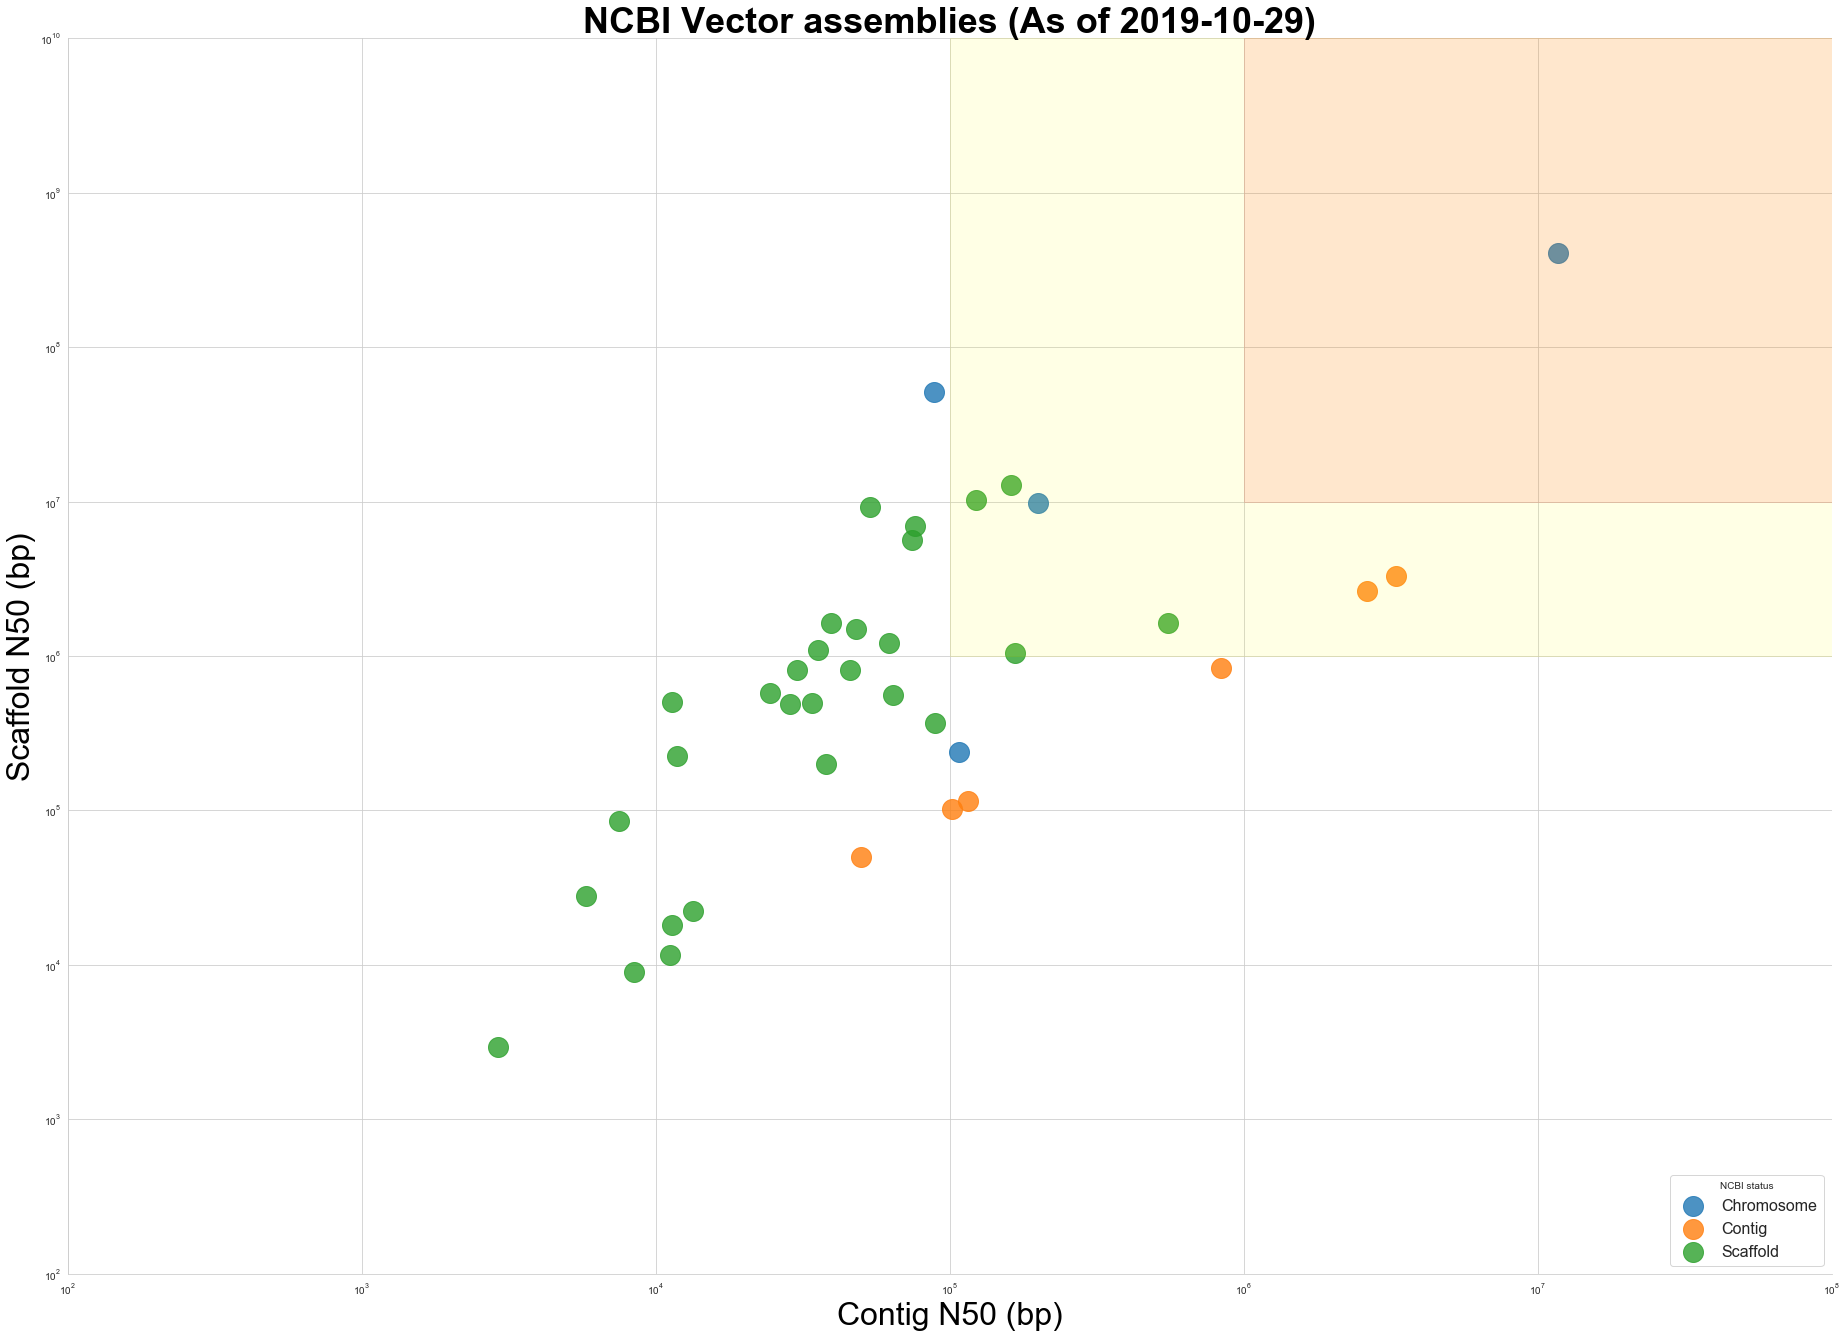

In [65]:
plot_contig_N50_vs_scaffold_N50(df_vectorbase, 'NCBI Vector assemblies', point_size=400)

In [66]:
fig = px.scatter(df_vectorbase, x='contig_n50', y='scaffold_n50', color='family',size='total_length', title='Vector Genomes Assembly Statistics', text='name_abreviation', hover_data=['species'], log_x=True, log_y=True, template='plotly_white')
#fig.update_traces(marker=dict(size=20, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
#fig.update_traces(marker=dict(size=20, line=dict(width=2, color='DarkSlateGrrey')), selector=dict(mode='markers'))
fig.update_traces(textposition='top center')
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['species', 'contig_n50', 'scaffold_n50', 'total_length', 'status', 'ass_accession', 'ass_release_date', 'genera', 'species_only', 'date_time_test', 'year', 'name_abreviation'] but received: family

In [ ]:
plot_with_plotly(df_Drosophila)

## Try to plot the VGP code (3.4.2.etc) - will just do the contig and scaffold N50s)

In [ ]:
df_vectorbase.head()

In [67]:
# first num 
def N50_bp_to_VGP_scale(N50):
    N50 = int(N50)
    VGP_num = round(math.log10(N50/1000))
    return(VGP_num)

test_contig_n50 = int(11758062)
test_scaffold_n50 = int(409777670)

N50_bp_to_VGP_scale(test_contig_n50)

NameError: global name 'math' is not defined

In [68]:
#df_vectorbase['VGP_scale'] = pd.api  N50_bp_to_VGP_scale(df_vectorbase['contig_n50'], df_vectorbase['scaffold_n50'])

df_vectorbase['contig_VGP_Scale'] = df_vectorbase.contig_n50.apply(N50_bp_to_VGP_scale)
df_vectorbase['scaffold_VGP_Scale'] = df_vectorbase.scaffold_n50.apply(N50_bp_to_VGP_scale)
df_vectorbase['VGP_assembly_score'] = df_vectorbase.contig_VGP_Scale + df_vectorbase.scaffold_VGP_Scale/10
df_vectorbase.VGP_assembly_score = df_vectorbase.VGP_assembly_score.apply(float)
df_vectorbase.head()

NameError: global name 'math' is not defined

In [69]:
df_vectorbase.VGP_assembly_score.plot(kind='hist')

AttributeError: 'DataFrame' object has no attribute 'VGP_assembly_score'

# I'm not sure I like this very much!